# CRYPTO ANALYSIS AND ML MODEL

In [2]:
import pandas as pd 
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pylab import rcParams

def correlations_analysis(df):
    display(df.corr())
    sns.pairplot(df)
    plt.show()
    sns.heatmap(df.corr(), annot=True)
    plt.show()

# AD FULER TEST FOR STATIONALITY 
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
def stationary_test(df):
        btc_stationarityTest = adfuller(df, autolag='AIC')
        if btc_stationarityTest[1] <= 0.05:
            return print(" is stationary")
        else:
            return print(" is NOT stationary")

/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
crypto_df = pd.read_csv("../final_data/crypto_series.csv")
# crypto_df = crypto_df.set_index('date')
# crypto_df_no_date= crypto_df.drop('date', axis=1)

,btc_p,ltc_p,eth_p,xrp_p,doge_p
btc_p,1.000000,0.789471,0.928318,0.649318,0.754378
ltc_p,0.789471,1.000000,0.753202,0.802896,0.517265
eth_p,0.928318,0.753202,1.000000,0.669864,0.829190
xrp_p,0.649318,0.802896,0.669864,1.000000,0.566191
doge_p,0.754378,0.517265,0.829190,0.566191,1.000000


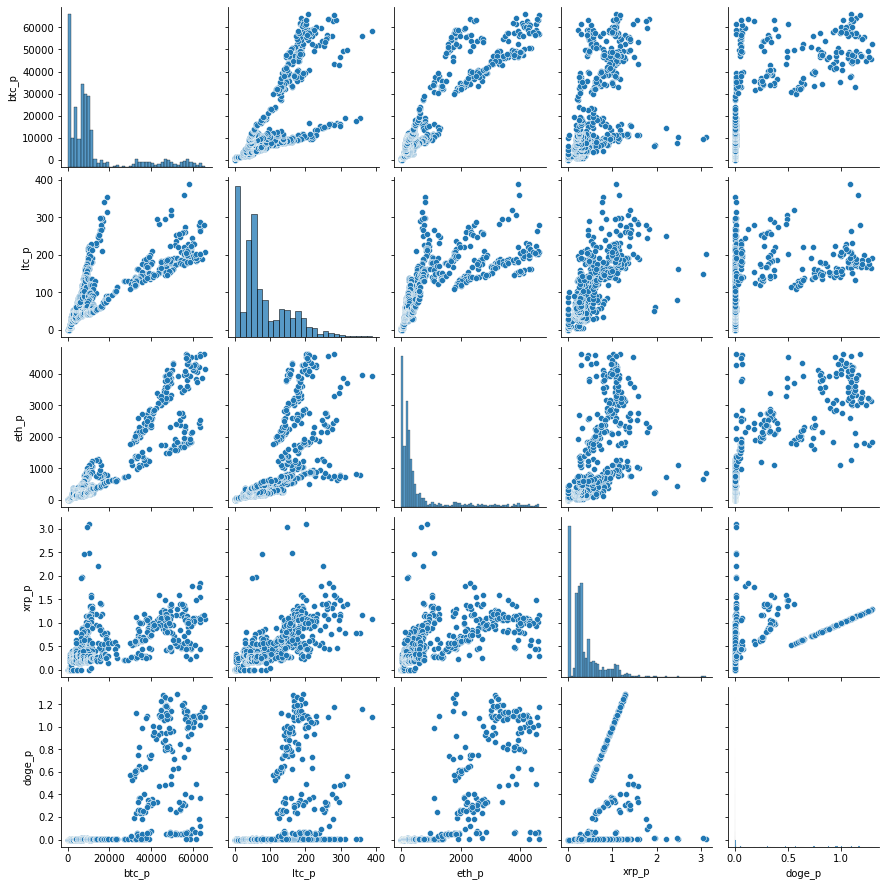

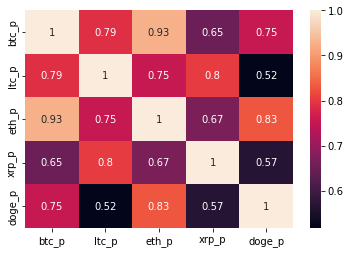

In [4]:
correlations_analysis(crypto_df)

# TIME SERIES ANALYSIS 

In [5]:
crypto_df = crypto_df.set_index('date')
# Standardize
scaler = MinMaxScaler()
crypto_df_s = scaler.fit_transform(crypto_df)

# Convert to DF
crypto_df = pd.DataFrame(crypto_df_s, columns=crypto_df.columns)

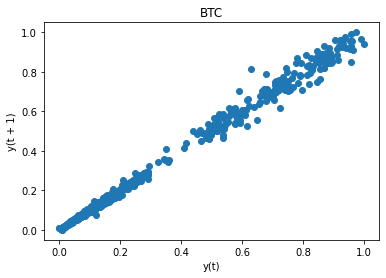

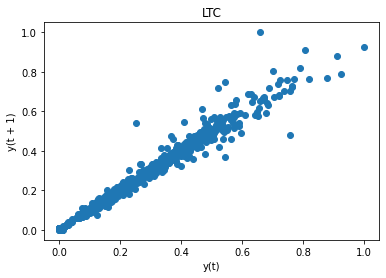

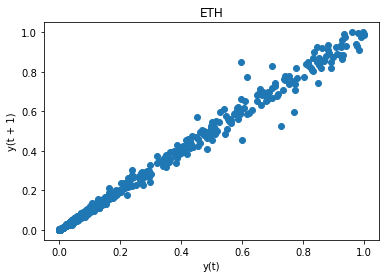

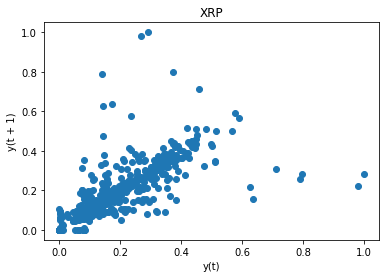

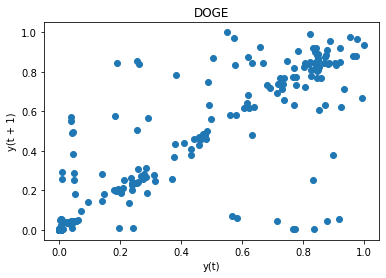

In [6]:
# All ryptos are highly autocorrelated 
lag_plot(crypto_df.btc_p) 
plt.title('BTC')
plt.show()
lag_plot(crypto_df.ltc_p)
plt.title('LTC')
plt.show()
lag_plot(crypto_df.eth_p) 
plt.title('ETH')
plt.show()
lag_plot(crypto_df.xrp_p) 
plt.title('XRP')
plt.show()
lag_plot(crypto_df.doge_p) 
plt.title('DOGE')
plt.show()

In [7]:
#########################################################################################
# STRONG AUTOCORRELATION (The value for period 't' is strongly dependent from value (t-1))
# They are stringly autocorrelated at the beggigning, more stable, then flcutuations are higher when the value increases
# There is a break n the plot on BTC due t big fluctuations (EMOTION RESPONSE ? )
#########################################################################################

In [8]:
# # Separate sub DF 
BTC = crypto_df[['btc_p']]
LTC = crypto_df[['ltc_p']]
ETH = crypto_df[['eth_p']]
XRP = crypto_df[['xrp_p']]
DOGE= crypto_df[['doge_p']]

In [9]:
crypto_df.btc_p

0       0.006460
1       0.006532
2       0.006511
3       0.006934
4       0.006801
          ...   
1282    0.707016
1283    0.710192
1284    0.740900
1285    0.736341
1286    0.720035
Name: btc_p, Length: 1287, dtype: float64

# BTC

In [10]:
# AD FULER TEST FOR STATIONALITY 
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, time series data has stationarity
stationary_test(crypto_df[['btc_p']])

 is NOT stationary


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
BTC  mean: 0.18836250567688476


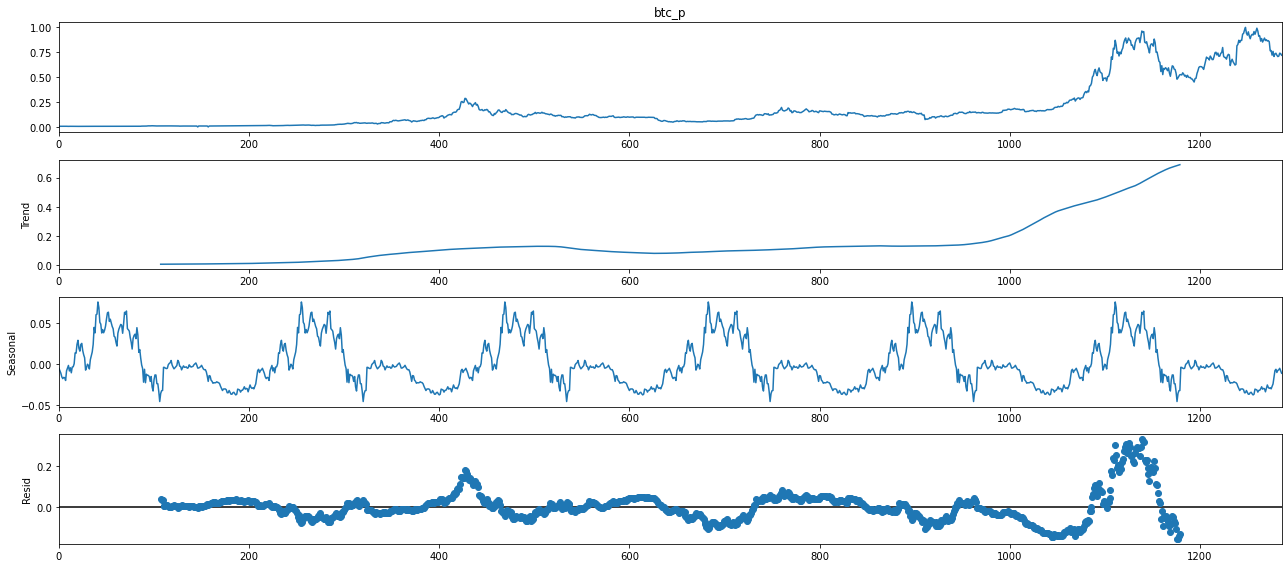

In [11]:
# # Check BTC Time Series for Seasonality:
%time
#period=214 shows the 214 days of trade as avreage on records 
rcParams['figure.figsize'] = 18, 8

res = sm.tsa.seasonal_decompose(crypto_df.btc_p, period=214,model='additive')  
print('BTC  mean:' ,crypto_df.btc_p.mean())
fig = res.plot()


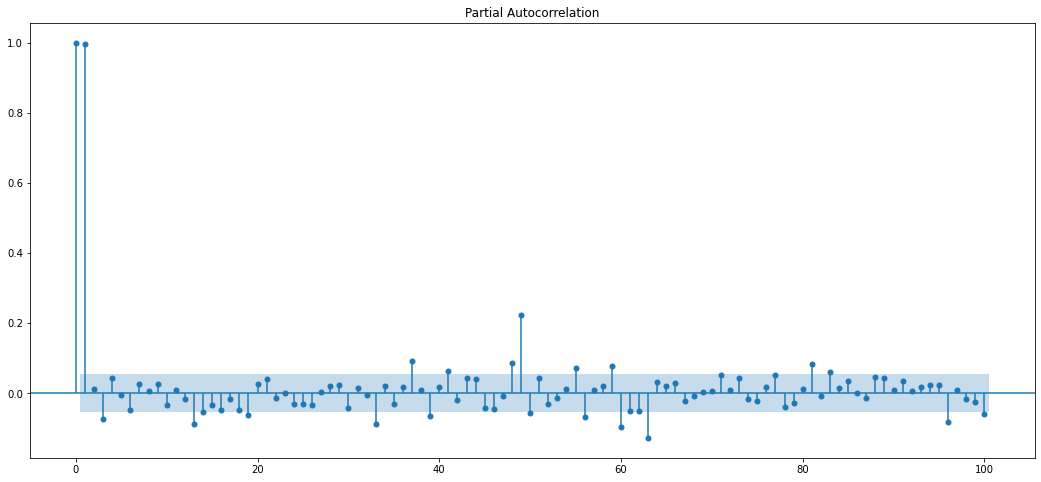

In [12]:
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data
pacf_100 = plot_pacf(crypto_df['btc_p'], lags=100)

In [15]:
train_btc

0       0.006460
1       0.006532
2       0.006511
3       0.006934
4       0.006801
          ...   
1182    0.543694
1183    0.530715
1184    0.510293
1185    0.518431
1186    0.497945
Name: btc_p, Length: 1187, dtype: float64

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs
Root Mean Square Error: 0.17998168862768837
Mean Square Error:      0.032393408241274166
error %:                4.131796203579028


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


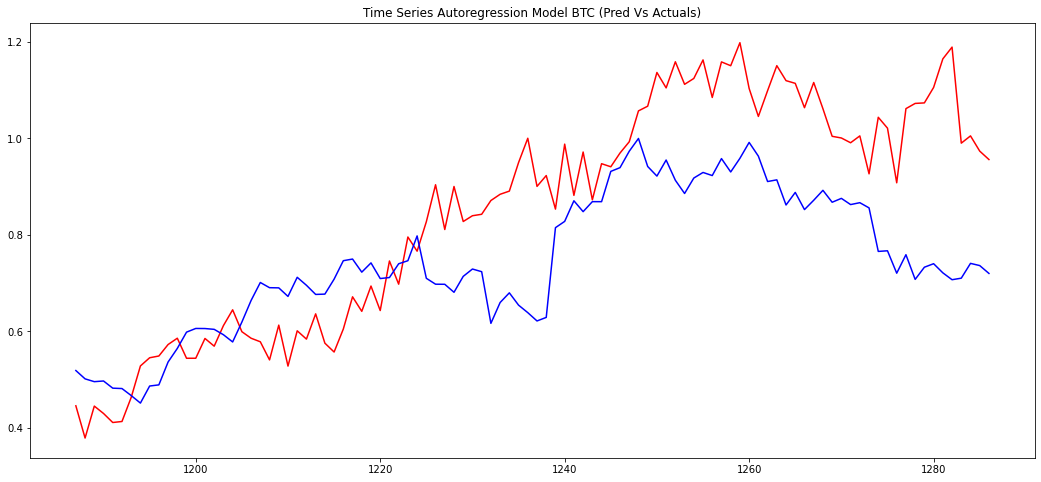

In [19]:
# AUTOREGRESSION MODEL:
    # Train Test Split
%time    
train_btc = crypto_df['btc_p'][:len(crypto_df)-100]
test_btc = crypto_df['btc_p'][len(crypto_df)-100:]
# # Model the AR model with training data
ar_btc = AutoReg(train_btc, lags=300).fit()
    # Make the predictions
pred_ar_btc = ar_btc.predict(start=len(train_btc), end=len(train_btc)+len(test_btc)-1, dynamic=False)
#                      predict(start=len(gbp_train), end=len(gbp_train)+len(gbp_test)-1, dynamic=False)
# print(ar_btc.summary())
    # Accuracy
MSE_AR_btc = mean_squared_error(test_btc, pred_ar_btc)
RMSE_AR_btc = math.sqrt(MSE_AR_btc)
    # Plot the prediction vs test data
plt.plot(pred_ar_btc, color='red')
plt.plot(test_btc, color='blue')
plt.title('Time Series Autoregression Model BTC (Pred Vs Actuals)')
# plt.title('Time Series AR Model BTC pred Vs BTC Actuals')

print("Root Mean Square Error:", RMSE_AR_btc)
print("Mean Square Error:     ",MSE_AR_btc)
print("error %:               " , np.mean(test_btc/RMSE_AR_btc))


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Square Error:  0.1713901199543675
Mean Square Error:       0.029374573217972485
error %:                 3.9500659903161317


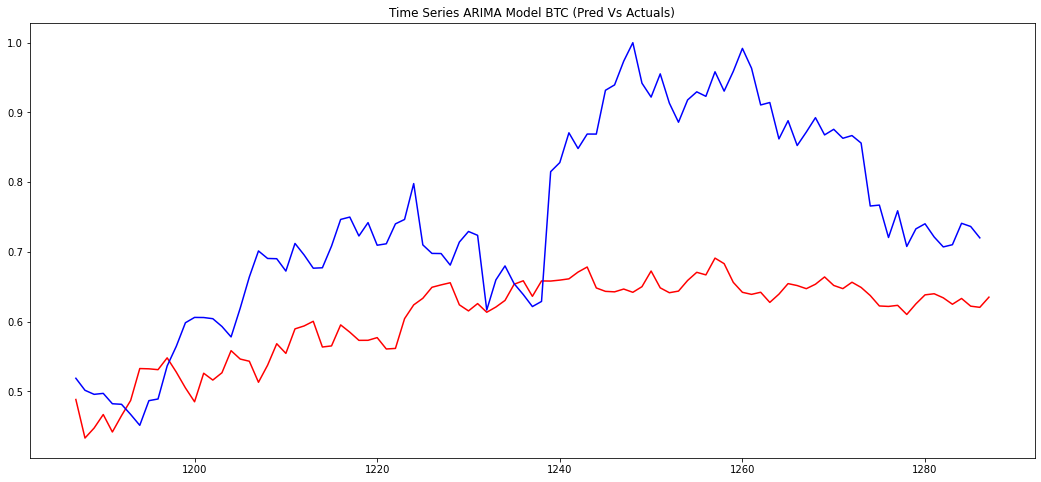

In [21]:
    # ARIMA 
%time
train_btc = crypto_df['btc_p'][:len(crypto_df)-100]
test_btc = crypto_df['btc_p'][len(crypto_df)-100:]
model = ARIMA(train_btc, order=(50, 1, 1)) 
    # p = number of lag terms taken into account, periods back
    # d = number of times the terms are differenced
    # q = moving average window
model_fit = model.fit()
predictions_btc = model_fit.predict(len(crypto_df)-100, len(crypto_df))
#Model accuracy
MSE_ARIMA_btc = np.square(np.subtract(test_btc,predictions_btc)).mean() 
RMSE_ARIMA_btc = math.sqrt(MSE_ARIMA_btc)
#     # Plot the prediction vs test data
plt.plot(predictions_btc, color='red')
plt.plot(test_btc, color='blue')
plt.title('Time Series ARIMA Model BTC (Pred Vs Actuals)')

print("Root Mean Square Error: ",RMSE_ARIMA_btc)
print("Mean Square Error:      ",MSE_ARIMA_btc)
print("error %:                ",MSE_ARIMA_btc/np.mean(test_btc)*100)

# LTC

In [212]:
# AD FULER TEST FOR STATIONALITY 
stationary_test(crypto_df[['ltc_p']])


 is NOT stationary


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
LTC  mean: 0.19580974450315577


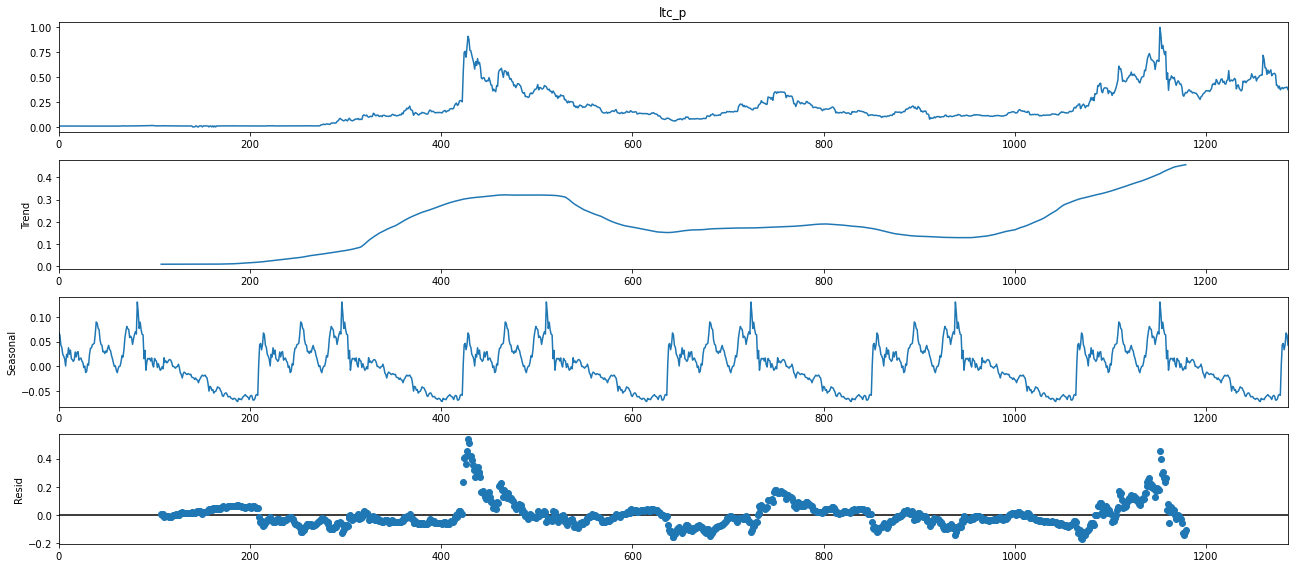

In [71]:
#period=214 shows the 214 days of trade as avreage on records 
%time
rcParams['figure.figsize'] = 18, 8
res = sm.tsa.seasonal_decompose(crypto_df.ltc_p, period=214,model='additive')
print('LTC  mean:' ,crypto_df.ltc_p.mean())
fig = res.plot()

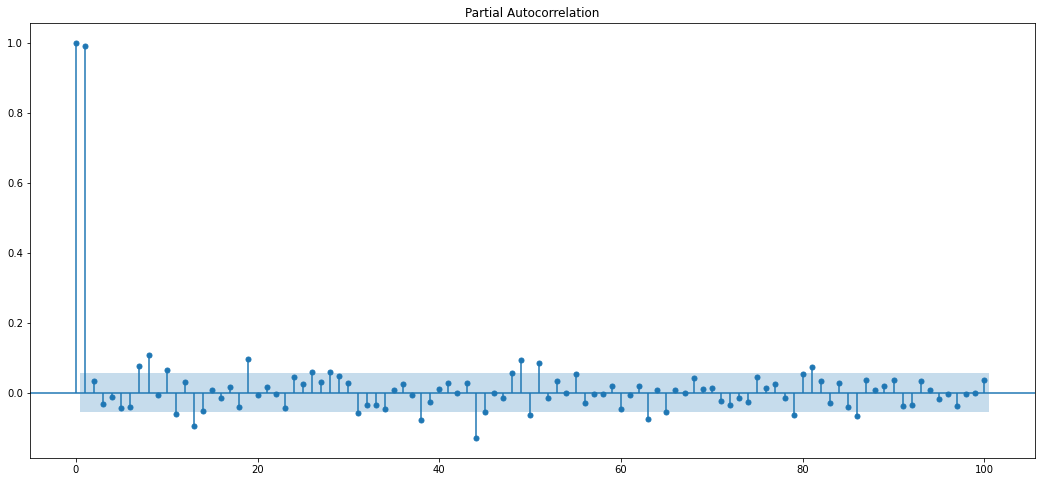

In [105]:
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data
pacf_100 = plot_pacf(crypto_df['ltc_p'], lags=100)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
Root Mean Square Error: 0.3296689878410562
Mean Square Error:      0.10868164154414646
error %:                0.7435616979735404


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


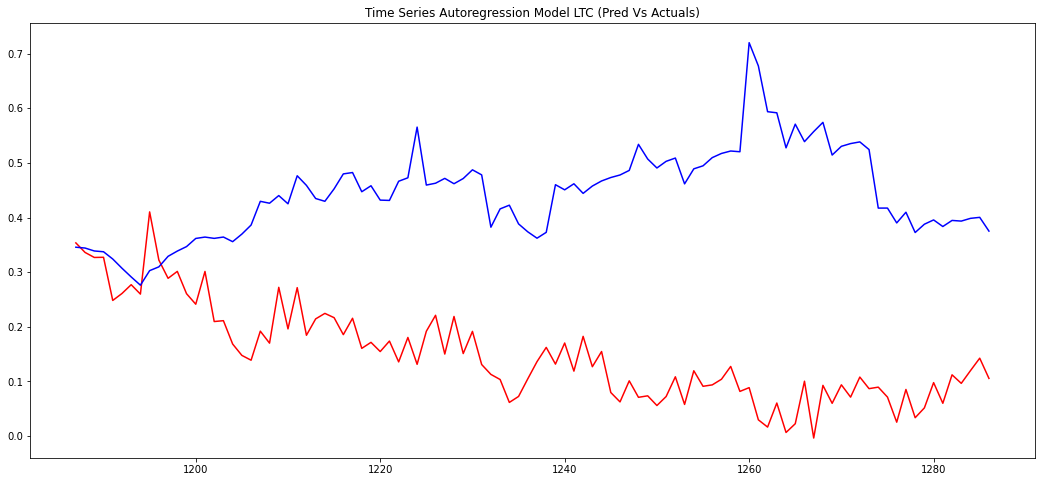

In [86]:
# AUTOREGRESSION MODEL:
    # Train Test Split
%time
train_ltc = crypto_df['ltc_p'][:len(crypto_df)-100]
test_ltc = crypto_df['ltc_p'][len(crypto_df)-100:]
    # Instantiate and fit the AR model with training data
ar_ltc = AutoReg(train_ltc, lags=300).fit()
    # Make the predictions
pred_ar_ltc = ar_ltc.predict(start=len(train_ltc), end=(len(crypto_df)-1), dynamic=False)
# print(ar_ltc.summary())
    # Accuracy
MSE_AR_ltc = mean_squared_error(test_ltc, pred_ar_ltc)
RMSE_AR_ltc = math.sqrt(MSE_AR_ltc)
pred_ar_ltc_check = pred_ar_ltc.reset_index(drop=True)
    # Plot the prediction vs test data
plt.plot(pred_ar_ltc, color='red')
plt.plot(test_ltc, color='blue')
plt.title('Time Series Autoregression Model LTC (Pred Vs Actuals)')

print("Root Mean Square Error:", RMSE_AR_ltc)
print("Mean Square Error:     ",MSE_AR_ltc)
print("error :               " , RMSE_AR_ltc/np.mean(test_ltc))


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Square Error:  0.16161986363225275
Mean Square Error:       0.026120980320507973
error % :                 5.8915339920340255


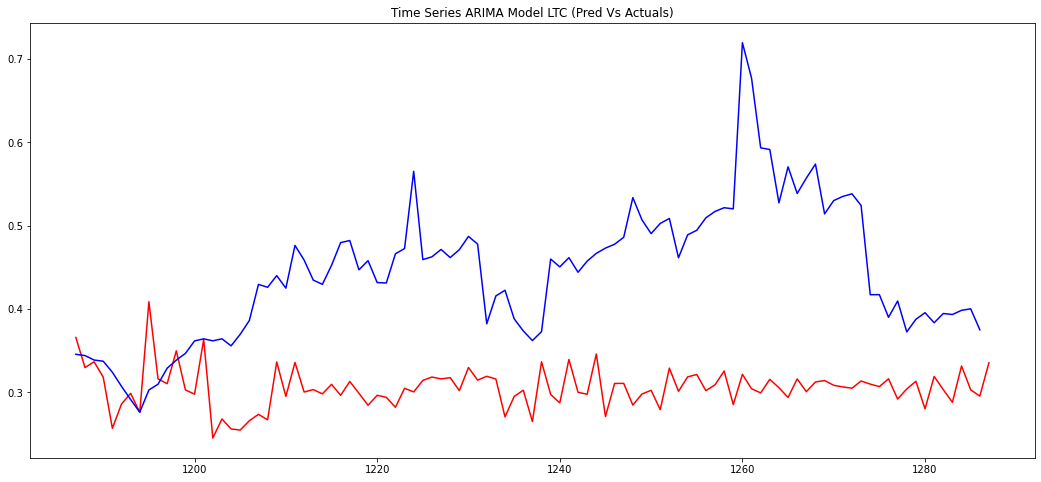

In [23]:
    # ARIMA 
%time
train_ltc = crypto_df['ltc_p'][:len(crypto_df)-100]
test_ltc = crypto_df['ltc_p'][len(crypto_df)-100:]
model = ARIMA(train_ltc, order=(50, 1, 1)) 
    # p = number of lag terms taken into account, periods back
    # d = number of times the terms are differenced
    # q = moving average window
model_fit = model.fit()
predictions_ltc = model_fit.predict(len(crypto_df)-100, len(crypto_df))
#Model accuracy
MSE_ARIMA_ltc = np.square(np.subtract(test_ltc,predictions_ltc)).mean() 
RMSE_ARIMA_ltc = math.sqrt(MSE_ARIMA_ltc)
#     # Plot the prediction vs test data
plt.plot(predictions_ltc, color='red')
plt.plot(test_ltc, color='blue')
plt.title('Time Series ARIMA Model LTC (Pred Vs Actuals)')

print("Root Mean Square Error: ",RMSE_ARIMA_ltc)
print("Mean Square Error:      ",MSE_ARIMA_ltc)
print("error % :                ",MSE_ARIMA_ltc/np.mean(test_ltc)*100)

# ETH 

In [149]:
# AD FULER TEST FOR STATIONALITY 
stationary_test(crypto_df[['eth_p']])

 is NOT stationary


ETH  mean: 0.1362549686137286


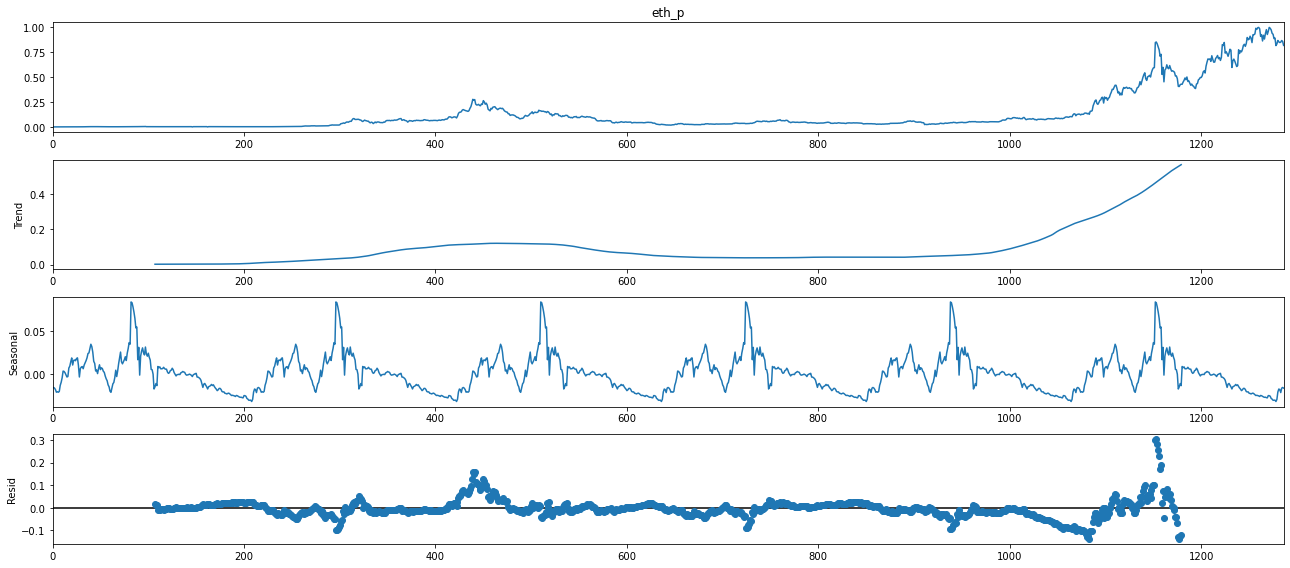

In [75]:
# # Check features for Seasonality with the complete DF curr_btc:

#period=214 shows the 214 days of trade as avreage on records 
rcParams['figure.figsize'] = 18, 8

res = sm.tsa.seasonal_decompose(crypto_df.eth_p, period=214,model='additive') 
print('ETH  mean:' ,crypto_df.eth_p.mean())
fig = res.plot()

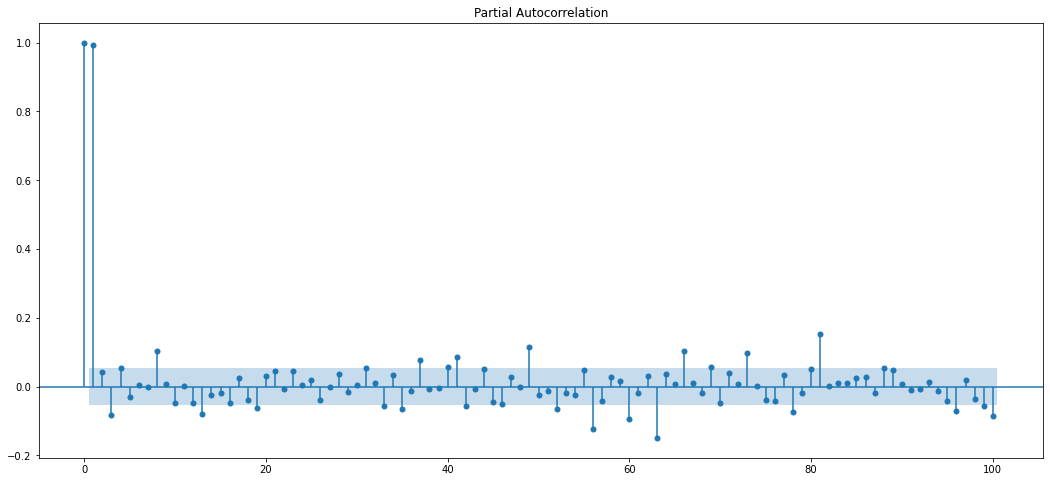

In [26]:
pacf_100 = plot_pacf(crypto_df['eth_p'], lags=100)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 11.9 µs


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Root Mean Square Error: 0.17998168862768837
Mean Square Error:      0.032393408241274166
error %:                0.24081755423659795


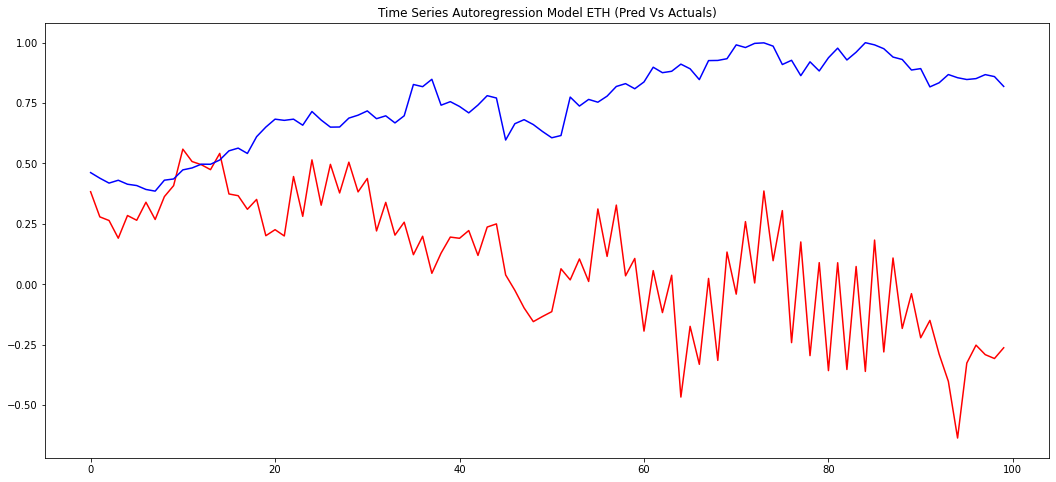

In [24]:
# AUTOREGRESSION MODEL:
    # Train Test Split
%time   
train_eth = crypto_df['eth_p'][:len(crypto_df)-100]
test_eth = crypto_df['eth_p'][len(crypto_df)-100:]
    # Instantiate and fit the AR model with training data
ar_eth = AutoReg(train_eth, lags=300).fit()
    # Make the predictions
pred_ar_eth = ar_eth.predict(start=len(train_eth), end=(len(crypto_df)-1), dynamic=False)
# print(ar_eth.summary())
    # Accuracy
MSE_AR_eth = mean_squared_error(test_btc, pred_ar_btc)
RMSE_AR_eth = math.sqrt(MSE_AR_eth)
pred_ar_eth_check = pred_ar_eth.reset_index(drop=True)
result_check_eth = test_eth.reset_index(drop=True)
    # Plot the prediction vs test data
plt.plot(pred_ar_eth_check, color='red')
plt.plot(result_check_eth, color='blue')
plt.title('Time Series Autoregression Model ETH (Pred Vs Actuals)')

print("Root Mean Square Error:", RMSE_AR_eth)
print("Mean Square Error:     ",MSE_AR_eth)
print("error %:               " , RMSE_AR_eth/np.mean(test_eth))


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Square Error:  0.3528581201641111
Mean Square Error:       0.12450885296575027
error %:                 0.1665942667870016


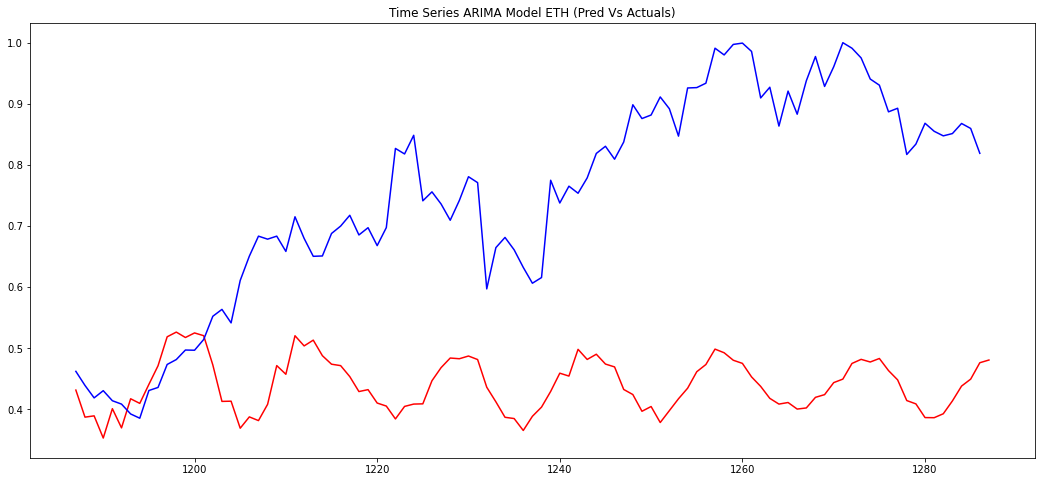

In [25]:
    # ARIMA 
%time
train_eth = crypto_df['eth_p'][:len(crypto_df)-100]
test_eth = crypto_df['eth_p'][len(crypto_df)-100:]
model = ARIMA(train_eth, order=(50, 1, 1)) 
    # p = number of lag terms taken into account, periods back
    # d = number of times the terms are differenced
    # q = moving average window
model_fit = model.fit()
predictions_eth= model_fit.predict(len(crypto_df)-100, len(crypto_df))
#Model accuracy
MSE_ARIMA_eth = np.square(np.subtract(test_eth,predictions_eth)).mean() 
RMSE_ARIMA_eth = math.sqrt(MSE_ARIMA_eth)
#     # Plot the prediction vs test data
plt.plot(predictions_eth, color='red')
plt.plot(test_eth, color='blue')
plt.title('Time Series ARIMA Model ETH (Pred Vs Actuals)')

print("Root Mean Square Error: ",RMSE_ARIMA_eth)
print("Mean Square Error:      ",MSE_ARIMA_eth)
print("error %:                ",MSE_ARIMA_eth/np.mean(test_eth))

# XRP

In [182]:
# AD FULER TEST FOR STATIONALITY 
stationary_test(crypto_df[['xrp_p']])

 is NOT stationary


XRP  mean: 0.11886872230822824


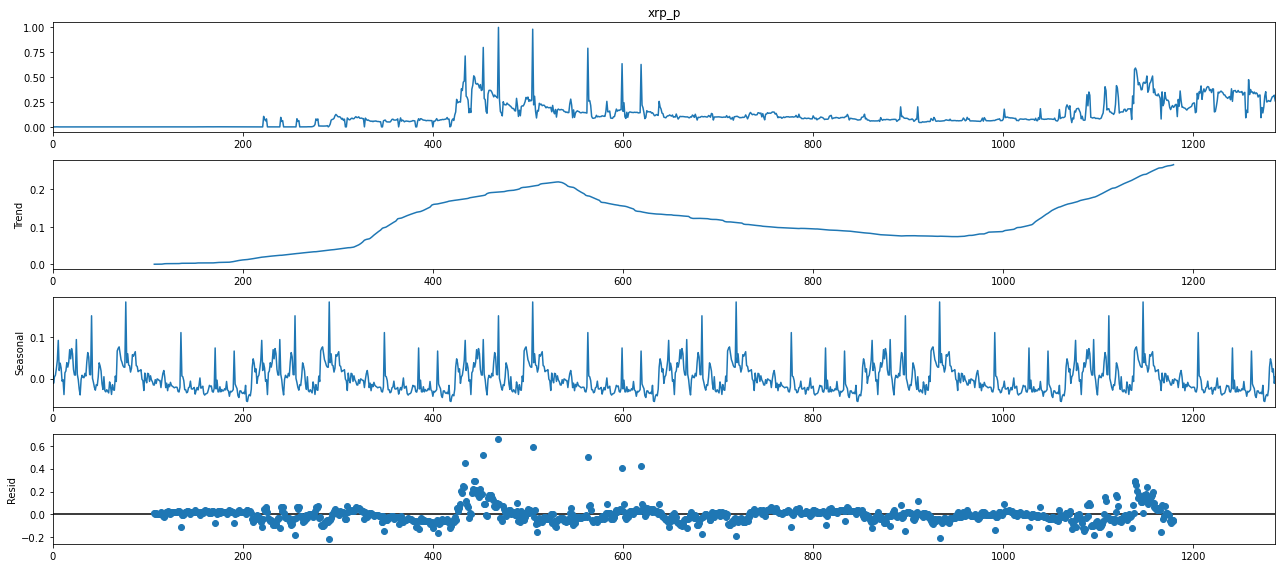

In [27]:
# # Check features for Seasonality with the complete DF curr_btc:
#period=214 shows the 214 days of trade as avreage on records 
rcParams['figure.figsize'] = 18, 8
res = sm.tsa.seasonal_decompose(crypto_df.xrp_p, period=214,model='additive') 
print('XRP  mean:' ,crypto_df.xrp_p.mean())
fig = res.plot()

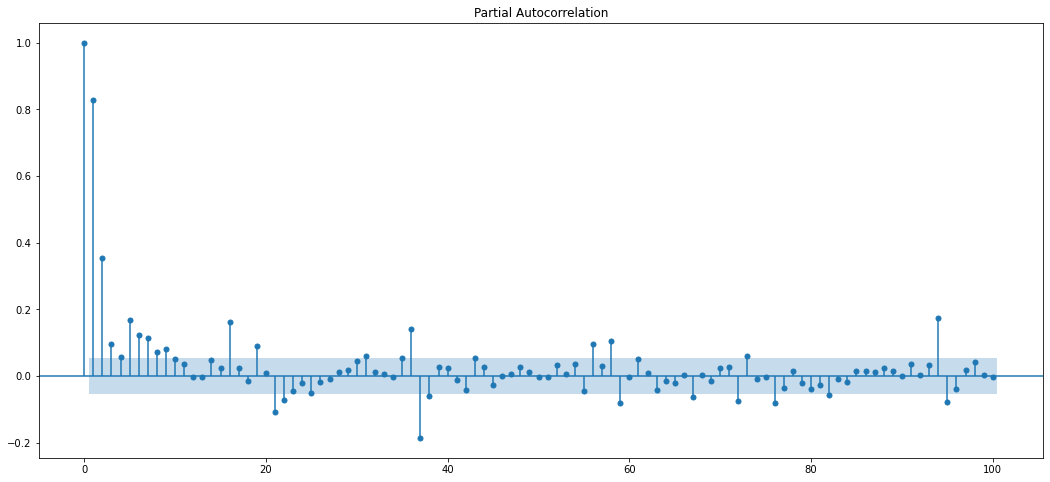

In [29]:
pacf_100 = plot_pacf(crypto_df['xrp_p'], lags=100)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
Root Mean Square Error: 0.1359599726275261
Mean Square Error:      0.018485114156877647
error %:                0.4636215912662276


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


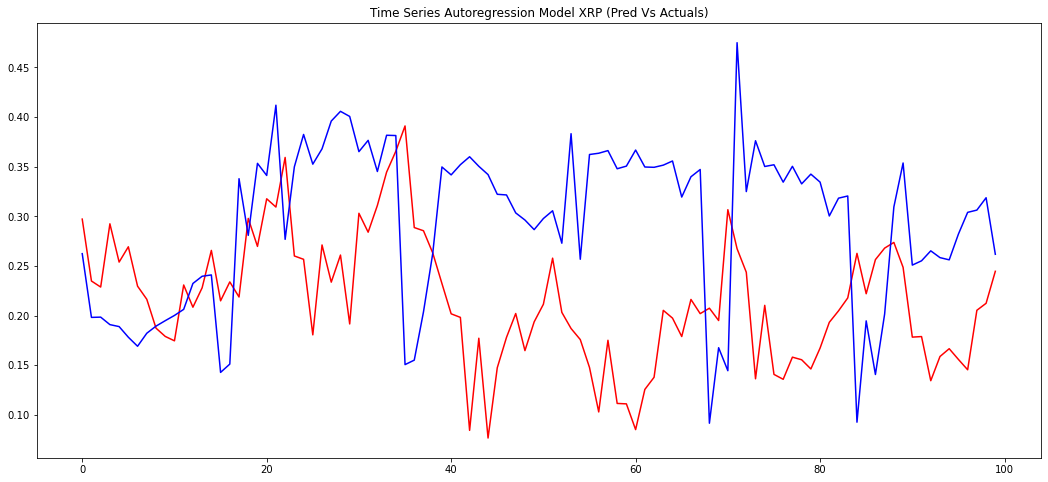

In [91]:
# AUTOREGRESSION MODEL:
    # Train Test Split
%time
train_xrp = crypto_df['xrp_p'][:len(crypto_df)-100]
test_xrp = crypto_df['xrp_p'][len(crypto_df)-100:]
    # Instantiate and fit the AR model with training data
ar_xrp = AutoReg(train_xrp, lags=300).fit()
    # Make the predictions
pred_ar_xrp = ar_xrp.predict(start=len(train_xrp), end=(len(crypto_df)-1), dynamic=False)
# print(ar_xrp.summary())
    # Accuracy
MSE_AR_xrp = mean_squared_error(test_xrp,pred_ar_xrp)
RMSE_AR_xrp = math.sqrt(MSE_AR_xrp)
pred_ar_xrp_check = pred_ar_xrp.reset_index(drop=True)
result_check_xrp = test_xrp.reset_index(drop=True)
    # Plot the prediction vs test data
plt.plot(pred_ar_xrp_check, color='red')
plt.plot(result_check_xrp, color='blue')
plt.title('Time Series Autoregression Model XRP (Pred Vs Actuals)')

print("Root Mean Square Error:", RMSE_AR_xrp)
print("Mean Square Error:     ",MSE_AR_xrp)
print("error %:               " , RMSE_AR_xrp/np.mean(test_xrp))


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Square Error:  0.08119157567476872
Mean Square Error:       0.006592071960551696
error %:                 0.022478872516878565


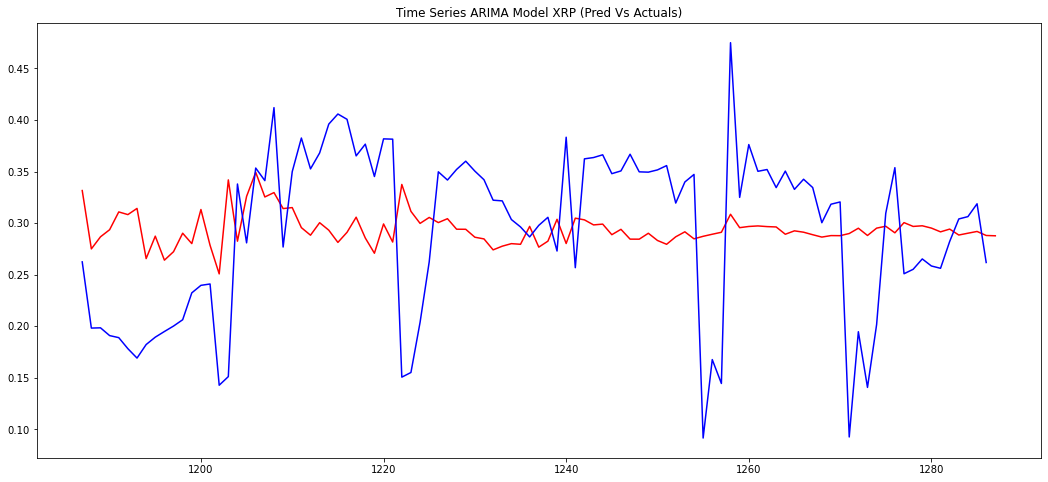

In [28]:
    # ARIMA 
%time
train_xrp = crypto_df['xrp_p'][:len(crypto_df)-100]
test_xrp = crypto_df['xrp_p'][len(crypto_df)-100:]
model = ARIMA(train_xrp, order=(50, 1, 1)) 
    # p = number of lag terms taken into account, periods back
    # d = number of times the terms are differenced
    # q = moving average window
model_fit = model.fit()
predictions_xrp= model_fit.predict(len(crypto_df)-100, len(crypto_df))
#Model accuracy
MSE_ARIMA_xrp = np.square(np.subtract(test_xrp,predictions_xrp)).mean() 
RMSE_ARIMA_xrp = math.sqrt(MSE_ARIMA_xrp)
#     # Plot the prediction vs test data
plt.plot(predictions_xrp, color='red')
plt.plot(test_xrp, color='blue')
plt.title('Time Series ARIMA Model XRP (Pred Vs Actuals)')

print("Root Mean Square Error: ",RMSE_ARIMA_xrp)
print("Mean Square Error:      ",MSE_ARIMA_xrp)
print("error %:                ",MSE_ARIMA_xrp/np.mean(test_xrp))

# DOGE

In [99]:
# AD FULER TEST FOR STATIONALITY 
stationary_test(crypto_df[['doge_p']])

 is NOT stationary


DOGE mean: 0.07104120653873548


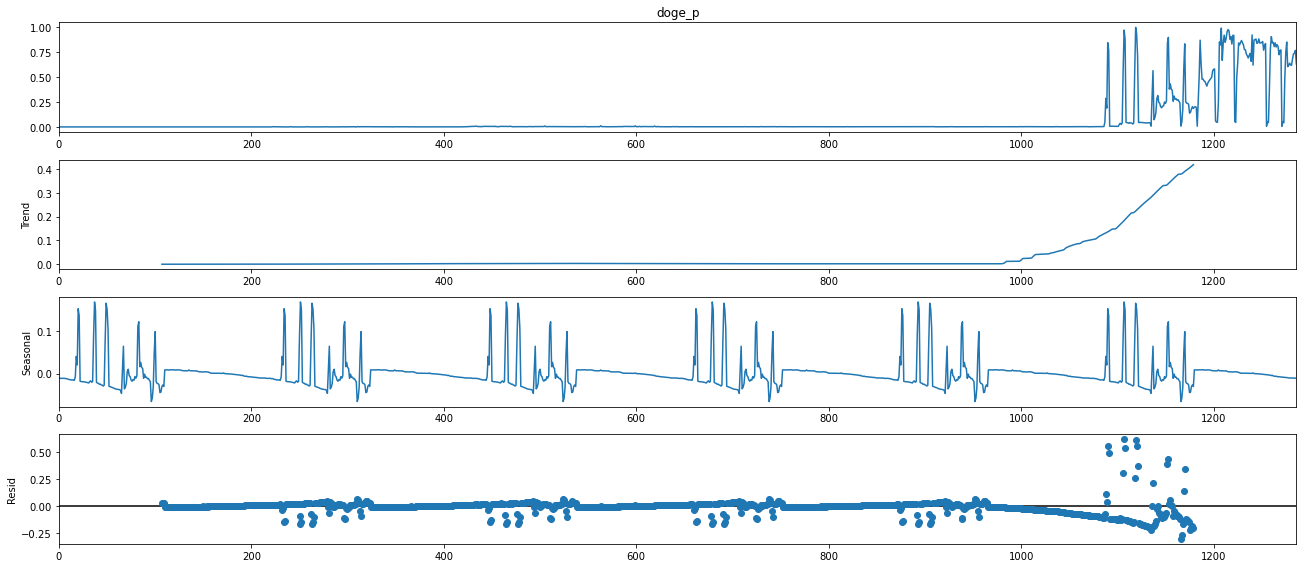

In [100]:
# # Check features for Seasonality with the complete DF curr_btc:
#period=214 shows the 214 days of trade as avreage on records 
rcParams['figure.figsize'] = 18, 8

res = sm.tsa.seasonal_decompose(crypto_df.doge_p, period=214,model='additive') 
print('DOGE mean:' ,crypto_df.doge_p.mean())
fig = res.plot()

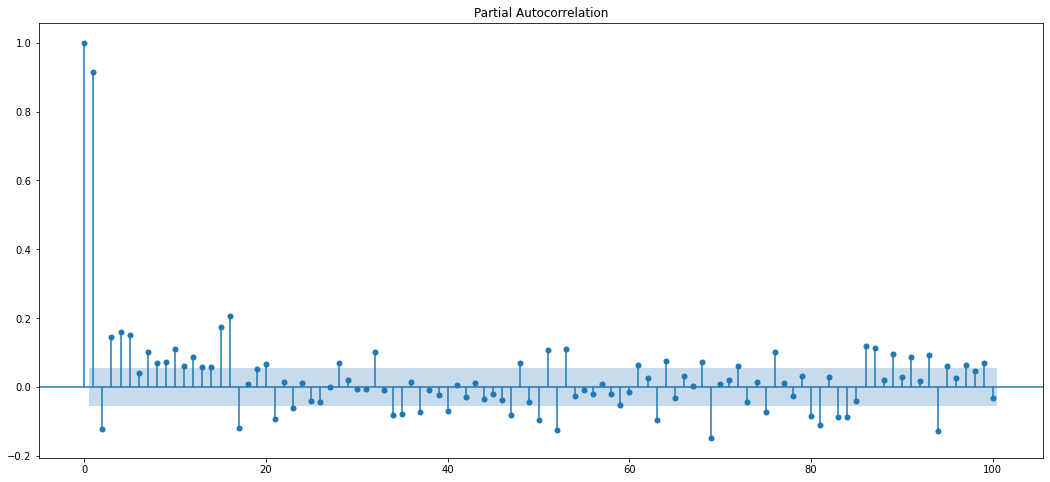

In [30]:
pacf_100 = plot_pacf(crypto_df['doge_p'], lags=100)

/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Root Mean Square Error: 17.56798928393755
Mean Square Error:      308.63424748054456
error %:                26.707084576396483


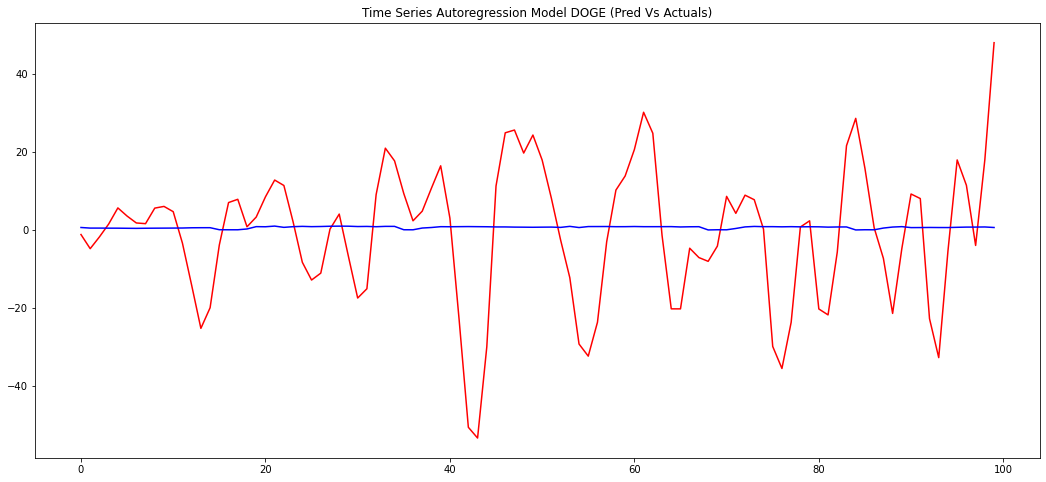

In [98]:
# AUTOREGRESSION MODEL:
    # Train Test Split
train_doge = crypto_df['doge_p'][:len(crypto_df)-100]
test_doge = crypto_df['doge_p'][len(crypto_df)-100:]
    # Instantiate and fit the AR model with training data
ar_doge = AutoReg(train_doge, lags=300).fit()
    # Make the predictions
pred_ar_doge = ar_doge.predict(start=len(train_doge), end=(len(crypto_df)-1), dynamic=False)
# print(ar_doge.summary())
    # Accuracy
MSE_AR_doge = mean_squared_error(test_doge, pred_ar_doge)
RMSE_AR_doge = math.sqrt(MSE_AR_doge)
pred_ar_doge_check = pred_ar_doge.reset_index(drop=True)
result_check_doge = test_doge.reset_index(drop=True)
    # Plot the prediction vs test data
plt.plot(pred_ar_doge_check, color='red')
plt.plot(result_check_doge, color='blue')
plt.title('Time Series Autoregression Model DOGE (Pred Vs Actuals)')

print("Root Mean Square Error:", RMSE_AR_doge)
print("Mean Square Error:     ",MSE_AR_doge)
print("error %:               " , RMSE_AR_doge/np.mean(test_doge))


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.06 µs


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Square Error:  0.47351421701867297
Mean Square Error:       0.22421571371880694
error %:                 0.34085562854482465


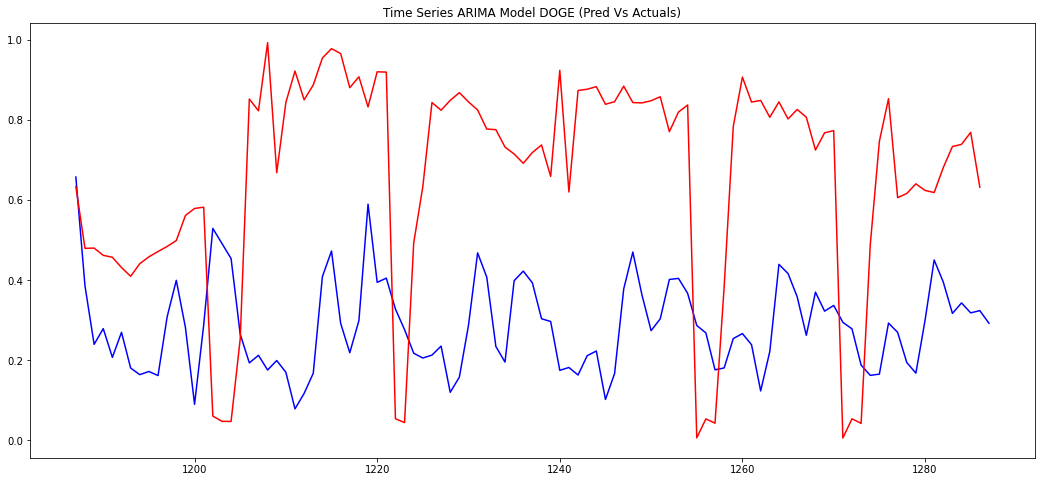

In [154]:
    # ARIMA 
%time
train_doge = crypto_df['doge_p'][:len(crypto_df)-100]
test_doge = crypto_df['doge_p'][len(crypto_df)-100:]
model = ARIMA(train_doge, order=(50, 1, 1)) 
    # p = number of lag terms taken into account, periods back
    # d = number of times the terms are differenced
    # q = moving average window
model_fit = model.fit()
predictions_doge= model_fit.predict(len(crypto_df)-100, len(crypto_df))
#Model accuracy
MSE_ARIMA_doge = np.square(np.subtract(test_doge,predictions_doge)).mean() 
RMSE_ARIMA_doge = math.sqrt(MSE_ARIMA_doge)
#     # Plot the prediction vs test data
plt.plot(predictions_doge, color='red')
plt.plot(test_doge, color='blue')
plt.title('Time Series ARIMA Model DOGE (Pred Vs Actuals)')

print("Root Mean Square Error: ",RMSE_ARIMA_doge)
print("Mean Square Error:      ",MSE_ARIMA_doge)
print("error %:                ",MSE_ARIMA_doge/np.mean(test_doge))

In [157]:
!git add .

In [158]:
!git commit -m'analysis ready'

[main 4971aee] analysis ready
 9 files changed, 8660 insertions(+), 5214 deletions(-)
 rewrite code/.ipynb_checkpoints/crypto_analysis-checkpoint.ipynb (79%)
 rename code/{initial_nb.ipynb => .ipynb_checkpoints/initial_nb-checkpoint.ipynb} (52%)
 rewrite code/crypto_analysis.ipynb (72%)
 create mode 100644 code/sandbox.ipynb


In [159]:
!git push

Enumerating objects: 12, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 4 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 2.26 MiB | 1.64 MiB/s, done.
Total 8 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/chrislacarte/crypto_analysis
   7228dbb..4971aee  main -> main
